# Semantic Kernel Snack

## Introduction

<details>
<summary><strong>What are AI agents?</strong></summary>
AI agents are modular, goal-directed systems that operate within clearly defined boundaries. 
Agents are built to use tools like APIs, and execute specific task-oriented workflows, reacting to prompts or real-time inputs.
They are excellent for targetted automation like suggestion code, but they do not collaborate or initiate, they do what we ask.
</details>

<details>
<summary><strong>What are Agentic AI Systems?</strong></summary>
Agentic AI is a system of multiple specialized agents autonomously working together towards a shared goal. 
These agents communicate between themselves using shared memory, and adapt to feedback, recursively planning and recovering from error. 
They recursively plan and recover from error.
Examples include research and supply chain optimisation teams powered by agents. 
</details>

<details>
<summary><strong>What is semantic Kernel (SK)?</strong></summary>
Semantic Kernel is an open-source SDK from Microsoft that acts as middleware between your application code and AI large language models (LLMs).
It provides a framework for building both standalone AI agents and collaborative multi-agent architectures that can work together toward complex goals. 
SK's Agent Framework is now generally availabile (GA), meaning it ensures a stable API with minimal breaking changes, ready for production use.

And semantic kernel is designed for enterprise-grade solutions with features like telemetry and filters for responsible AI. 
It supports multiple AI vendors like OpenAI, Azure OpenAI, and HuggingFace.
</details>

<details>
<summary><strong>What are the main components of Semantic Kernel?</strong></summary>
<ul>
  <li><strong>Kernel</strong>: The central orchestrator that manages plugins, memory, and AI services</li>
  <li><strong>Connectors</strong>: Integrations with different AI services (OpenAI, Azure OpenAI, etc.)</li>
  <li><strong>Plugins</strong>: Collections of functions that SK can invoke (both native code functions and AI-powered semantic functions)</li>
  <li><strong>Memory</strong>: System for storing, retrieving, and managing embeddings for semantic search</li>
  <li><strong>Planners</strong>: Components that help break down complex tasks into sequences of steps</li>
</ul>
</details>

## Import python package dependancies

In [1]:
#!pip install -q semantic-kernel==1.29.0 rich  python-dotenv==1.0.1

In [2]:
from typing import Annotated, List, Dict
import random
import yaml
from datetime import datetime
from IPython.display import Image, display
from semantic_kernel.kernel import Kernel
from semantic_kernel.functions import kernel_function, KernelFunctionFromPrompt, KernelArguments
from semantic_kernel.connectors.ai.open_ai import AzureChatCompletion
from semantic_kernel.contents.chat_history import ChatHistory
from semantic_kernel.connectors.ai.open_ai.prompt_execution_settings.azure_chat_prompt_execution_settings import (
    AzureChatPromptExecutionSettings,
)
from semantic_kernel.connectors.ai.function_choice_behavior import (
    FunctionChoiceBehavior,
)
from semantic_kernel.agents import ChatHistoryAgentThread, ChatCompletionAgent, AgentGroupChat
from semantic_kernel.agents.strategies import DefaultTerminationStrategy, SequentialSelectionStrategy, KernelFunctionSelectionStrategy
from semantic_kernel.agents.strategies.termination.termination_strategy import TerminationStrategy

## Bite 1 - Amuse-Bouche - The kernel and chat foundation

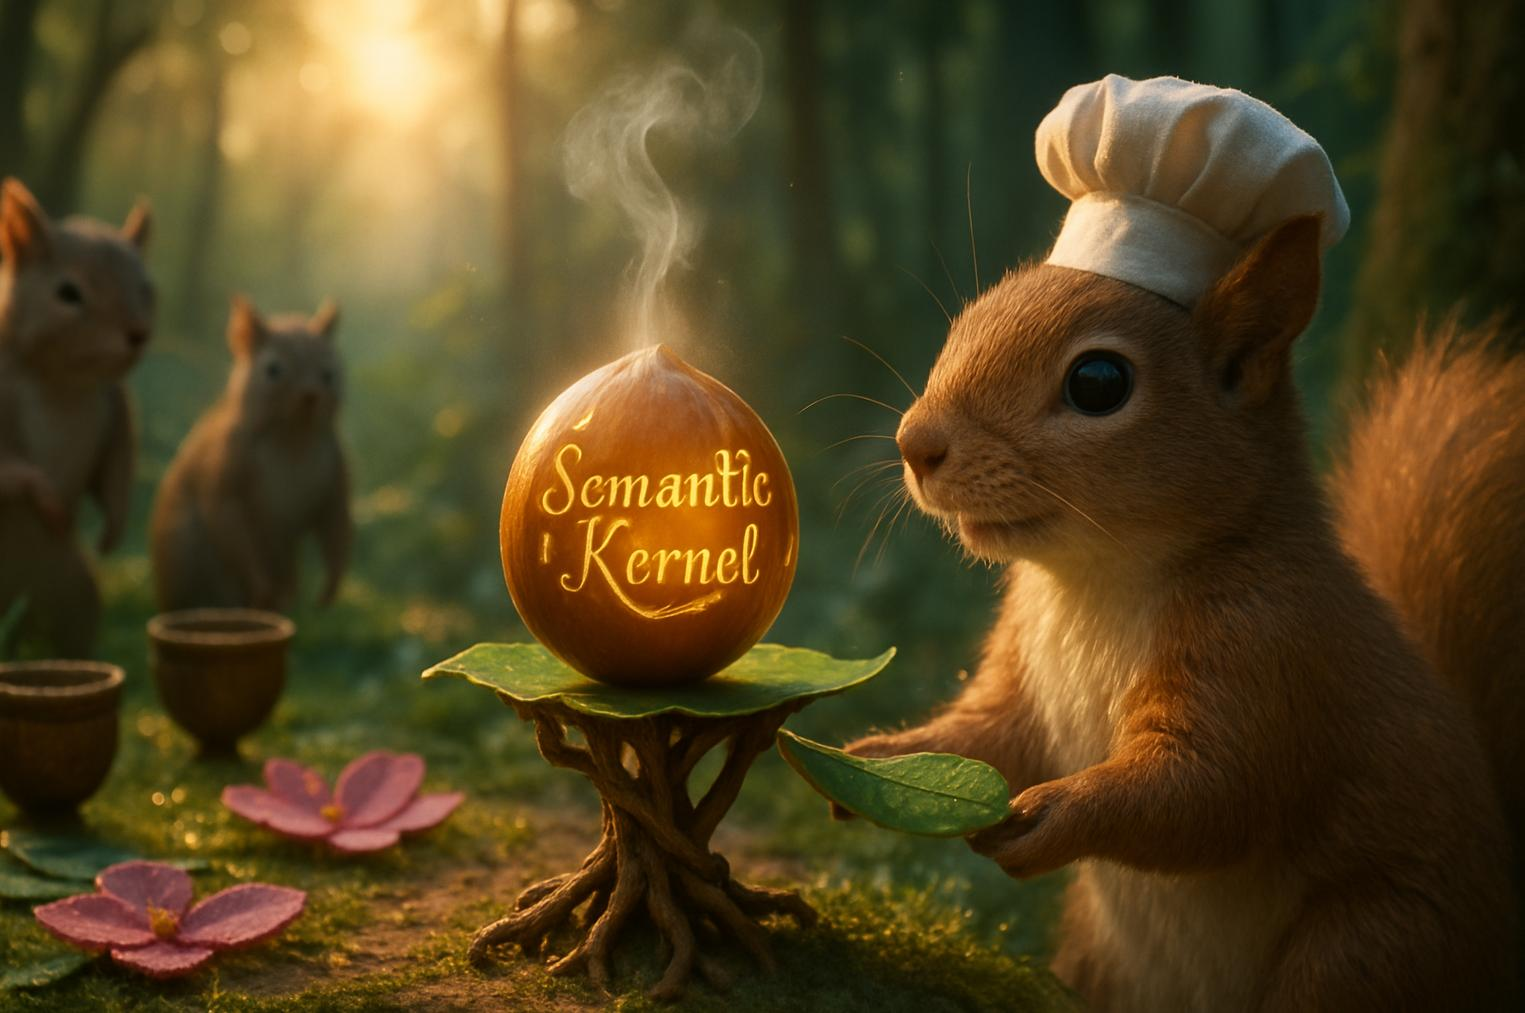

In [3]:
display(Image('assets/images/sk-bite-1-xs.jpeg', width=700))

<details>
<summary><b>More about kernel & chat completion setup</b></summary>

Our first step creates the kernal foundation for managing all AI services, functions, and plugins with SK.
We also configure an Azure OpenAI connection with chat completion, which reads in the credentials from a .env file automatically (you can override the .env values directly).
                 
**Note:** Both the kernel and `chat_completion` are used in multiple bite examples below.
</details>

In [4]:
# Create the kernel which is our core orchestration component
kernel = Kernel()

chat_completion = AzureChatCompletion()

## Bite 2 - Appetizer - Simple conversation chat flavours

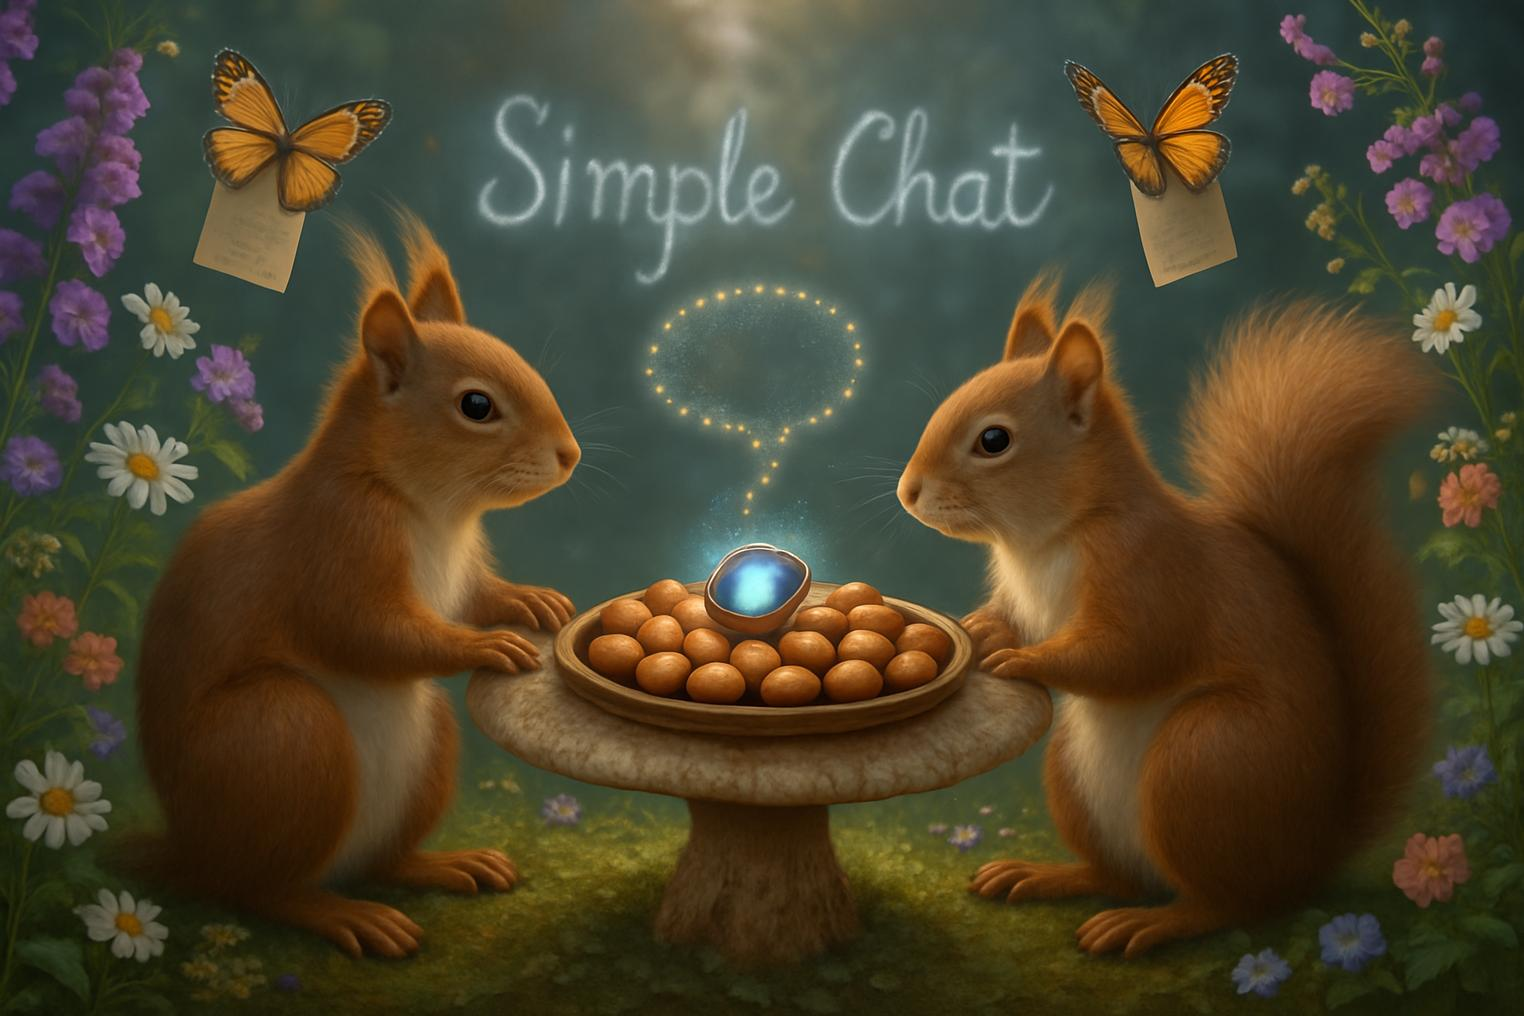

In [5]:
display(Image('assets/images/sk-bite-2-xs.jpeg', width=700))

<details>
<summary><b>More about simple chat completion</b></summary>

Here we create a basic example of using SK for chat completion, without the use of any agents, showing how to:
- Create a kernel instance
- Set up a chat completion service
- Manage a simple conversation with ChatHistory
- Invoke the kernel's `invoke_prompt` method to execute a prompt with the user input **healthy breakfast idea?** as a message to the conversation, and get a response
</details>

In [6]:
# Register the Azure OpenAI chat completion service with the kernel, making the chat service available for use
kernel.add_service(chat_completion)

# Create a new chat history and add a user message
chat_history = ChatHistory()
chat_history.add_user_message("I'm looking for a quick healthy breakfast idea that takes less than 10 minutes to prepare.")

# Execute the chat completion and await a response
result = await kernel.invoke_prompt(
    "{{$chat_history}}",
    chat_history=chat_history
)

print(result)

Here’s a quick and healthy breakfast idea that takes less than 10 minutes to prepare: **Greek Yogurt Parfait**.

### Ingredients:
- 1 cup of Greek yogurt (plain or flavored)
- 1/2 cup of mixed berries (fresh or frozen)
- 1/4 cup of granola or nuts (optional for crunch)
- A drizzle of honey or maple syrup (optional)
- A sprinkle of chia seeds or flaxseeds (optional)

### Instructions:
1. **Layer the Yogurt:** In a bowl or a glass, add the Greek yogurt as the base.
2. **Add the Berries:** Top the yogurt with mixed berries.
3. **Include Granola/Nuts:** If you like a bit of crunch, add granola or your choice of nuts on top.
4. **Sweeten (if desired):** Drizzle a little honey or maple syrup if you like it sweeter.
5. **Top with Seeds:** Sprinkle chia seeds or flaxseeds for added nutrition.

### Enjoy!
This breakfast is packed with protein, fiber, and antioxidants, and you can easily customize it based on your preferences. Plus, it's super quick to make!


## Bite 3 - Soup course - Using threads for natural, multi-turn conversational broth

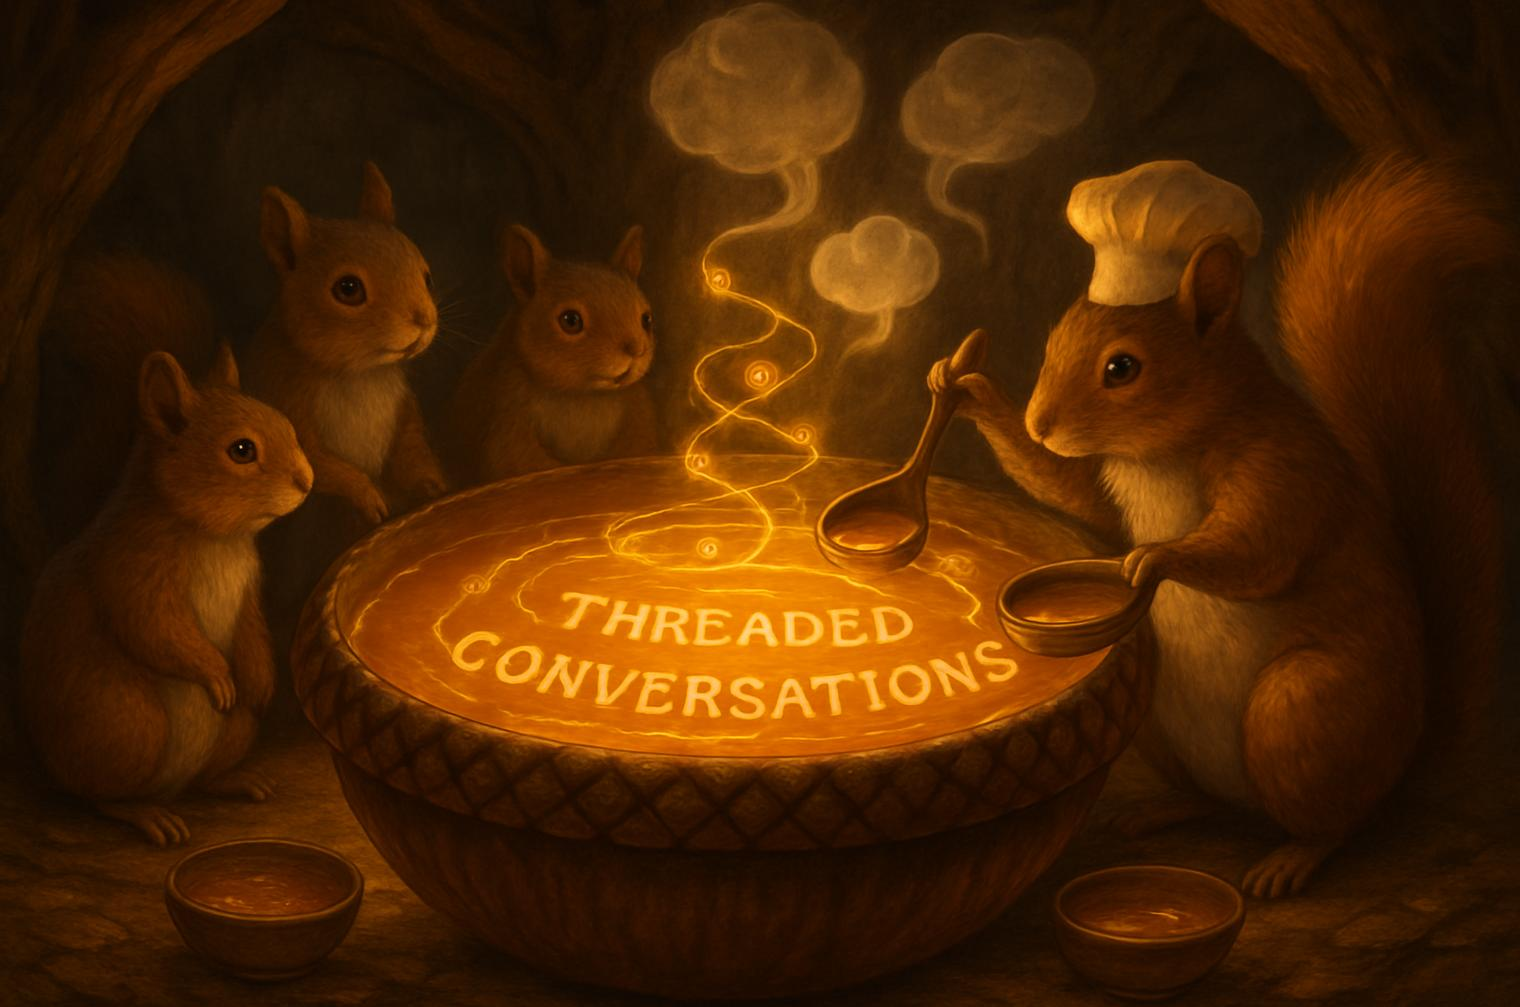

In [7]:
display(Image('assets/images/sk-bite-3-xs.jpeg', width=700))

<details>
<summary><b>More about Chef Zest's threads</b></summary>

Chef Zest maintains conversational context through `ChatHistoryAgentThread`, enabling natural, multi-turn culinary discussions.
This thread functionality stores the complete conversation history, allowing the agent to reference previous recommendations and build upon them in subsequent responses.

Without threads, each interaction would be isolated. Instead, Chef Zest creates a cohesive experience, progressing logically from dish suggestions to spice recommendations, drink pairings, and complementary desserts.
</details>

In [8]:
# Create a culinary adventure guide agent
food_agent = ChatCompletionAgent(
    service=chat_completion,
    name="flavor_explorer",
    instructions="""You are Chef Zest, a charismatic culinary adventure guide with a playful personality.
    You help food enthusiasts discover exciting dishes, unique ingredients, and hidden food gems around the world.
    Share fun food facts, unexpected flavor combinations, and quirky culinary traditions.
    Your tone is enthusiastic, witty, and slightly whimsical - like Anthony Bourdain meets Willy Wonka.
    Keep responses concise but packed with flavorful insights that make people hungry for food adventure!"""
)

# Initialize an empty thread to store conversation history
thread: ChatHistoryAgentThread = None

# Simulate a multi-turn conversation about culinary adventures
food_lover_questions = [
    "Hi Chef Zest! I'm bored with my usual dinner routine. Inspire me!",
    "That sounds interesting! What's a specific spice blend I should try for that dish?",
    "Could you recommend a drink that would pair well with this meal?",
    "Thanks! If I wanted to make a dessert that complements this entire experience, what would you suggest?",
]

for question in food_lover_questions:
    response = await food_agent.get_response(messages=question, thread=thread)
    thread = response.thread

# Display the complete conversation history
print("\n" + "="*50)
print("Complete Conversation History")
print("="*50)
async for message in thread.get_messages():
    prefix = "😋 Food Lover >" if message.role == "user" else "🌶️ Chef Zest >"
    print(f"\n{prefix} {message.content}")


Complete Conversation History

😋 Food Lover > Hi Chef Zest! I'm bored with my usual dinner routine. Inspire me!

🌶️ Chef Zest > Ahoy, culinary explorer! Ready to embark on a mouth-watering adventure? Let’s spice up that routine! 🎉

How about trying **Korean Gochujang Tacos**? Picture this: soft corn tortillas cradling marinated bulgogi beef, topped with crunchy cucumber slaw and zesty kimchi. It’s like a flavor explosion in a fiesta!

Or take a leap into the psychedelic world of **Savory Oatmeal**! Yes, you heard that right! Swap your sweet oats for an umami-packed bowl topped with a poached egg, sautéed mushrooms, and a drizzle of soy sauce. It's a cozy hug on a plate!

And if you’re feeling extra daring, why not whip up a **Coconut Curry Ice Cream**? Just blend coconut milk, curry powder, coconut sugar, and a pinch of salt, then churn it into creamy bliss. Your taste buds will be doing a happy dance!

So, what tickles your fancy? Let’s make dinner exciting again! 🍽️✨

😋 Food Lover >

## Bite 4 - Palate cleanser - real-time streaming sorbet

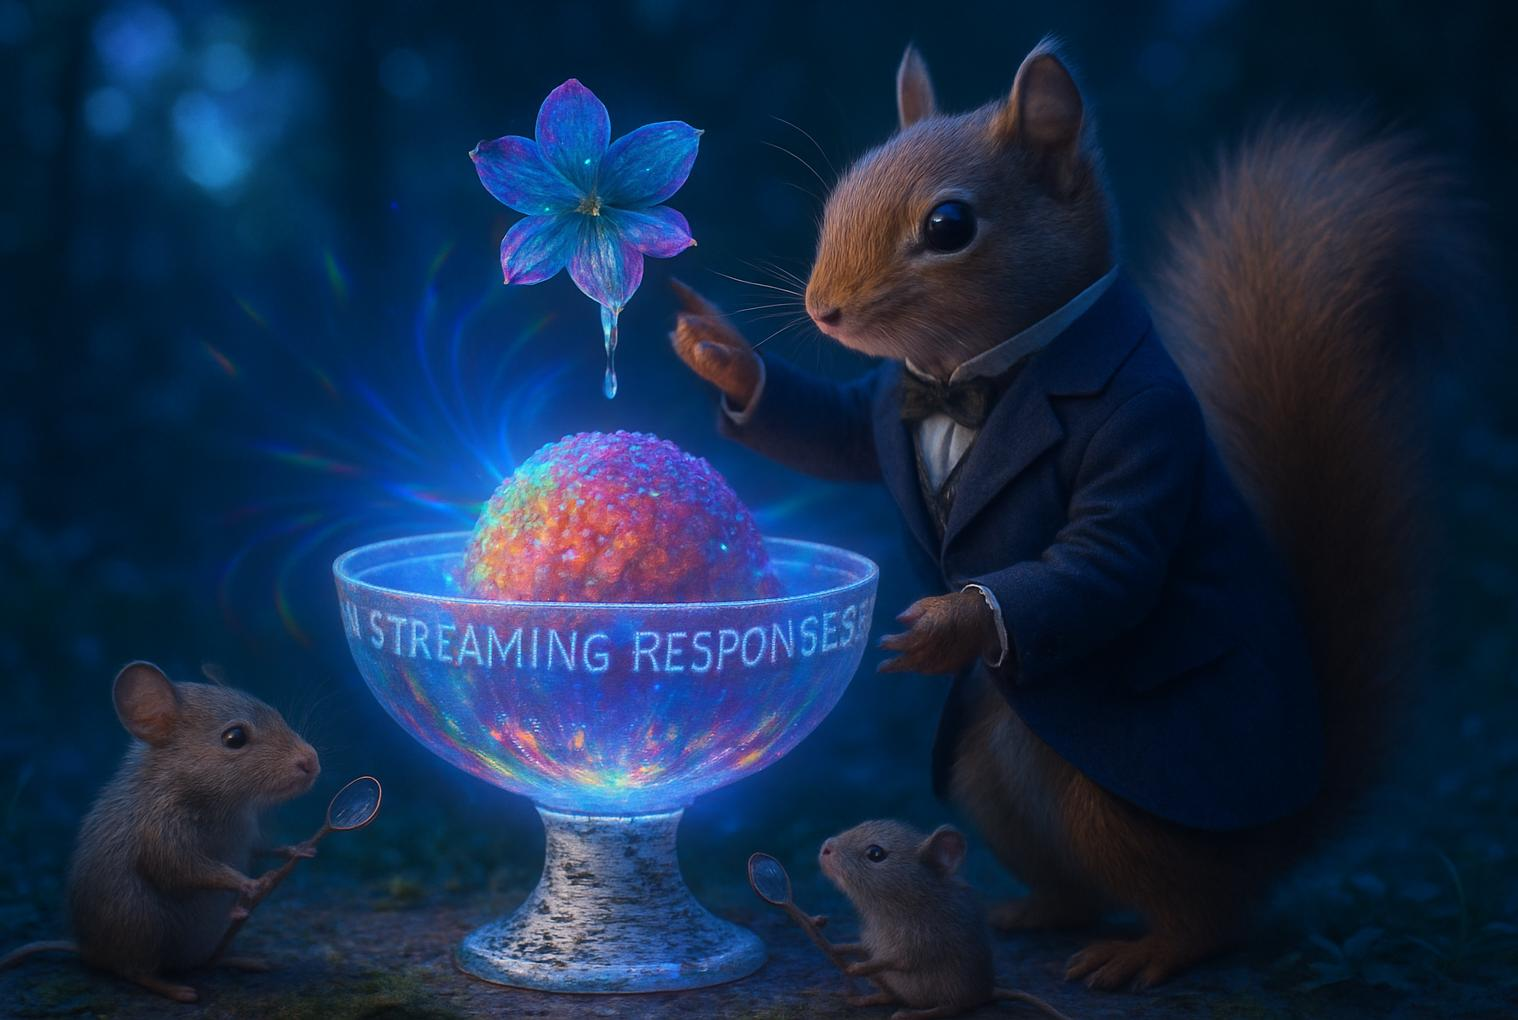

In [9]:
display(Image('assets/images/sk-bite-4-xs.jpeg', width=700))

<details>
<summary><b>More information about streaming responses</b></summary>

Rather than waiting for a complete response from the AI model before displaying anything to the user, we can continuously deliver the content as it's being generated.
This is really important in a real-time scenario like a customer support assistant to create a more dynamic and responsive experience.
To implement streaming in SK, we use the `invoke_stream()` method to get real-time updates from our agent. The agent streams its response chunk by chunk which we output.
</details>

In [10]:
culinary_agent = ChatCompletionAgent(
    service=AzureChatCompletion(),
    name="gourmet_chef",
    instructions="""You are Chef Zest, a charismatic creative culinary expert who can generate vivid and engaging recipes.
    When asked for recipe ideas, create detailed and mouth-watering content that brings the dish to life.
    Include creative ingredient combinations, sensory descriptions of flavors and aromas, and precise cooking techniques.
    Structure your responses with: 
    1. A catchy recipe name
    2. A brief story/origin of the dish
    3. Ingredients list
    4. Step-by-step cooking instructions
    5. Serving suggestions and pairing recommendations
    Keep recipes practical enough for home cooks while still being innovative and exciting.
    Generate content that is a maximum of 4 paragraphs for the story/description, followed by structured recipe content.
    """
)

recipe_prompt = "Create a unique fusion recipe that combines techniques or ingredients from two different culinary traditions."

response_chunks = []
character_count = 0
start_time = datetime.now()

# Use invoke_stream to get response chunks as they're generated
async for chunk in culinary_agent.invoke_stream(messages=recipe_prompt):
    if chunk.content:
        response_chunks.append(chunk.content.content)
        print(chunk.content, end="", flush=True)
        character_count += len(chunk.content.content)

end_time = datetime.now()
duration = (end_time - start_time).total_seconds()
print(f"\n\nStreaming stats:")
print(f"- Generated {character_count} characters in {duration:.2f} seconds")
print(f"- Average speed: {character_count / duration:.1f} characters/second")

full_response = "".join(response_chunks)

### Spicy Kimchi Tacos with Avocado Mango Salsa

From the bustling streets of Seoul to the vibrant taco stands of Mexico, this dish pays homage to two culinary powerhouses by seamlessly fusing the spicy tang of kimchi with the hearty flavors of a classic taco. The origins of this fusion recipe stem from a personal love affair with diverse cuisines. Who would have thought that ripe avocados and cultured cabbage could coexist beautifully? This dish offers a celebration of contrasting yet harmonious flavors, and it’s perfect for those who desire a taco that packs a punch and tells a story with every bite.

In our Spicy Kimchi Tacos, we’ll be using traditional corn tortillas as a base—soft and slightly charred, they deliver a nutty essence that complements the vibrant kimchi filling. Imagine crispy taco shells filled with a piquant mix of sautéed kimchi, taco-seasoned ground meat, and topped with a refreshing avocado mango salsa that dances with zest. The concept invites you to explore the

## Bite 5 - Main course - Extending AI model capabilities with semantic functions

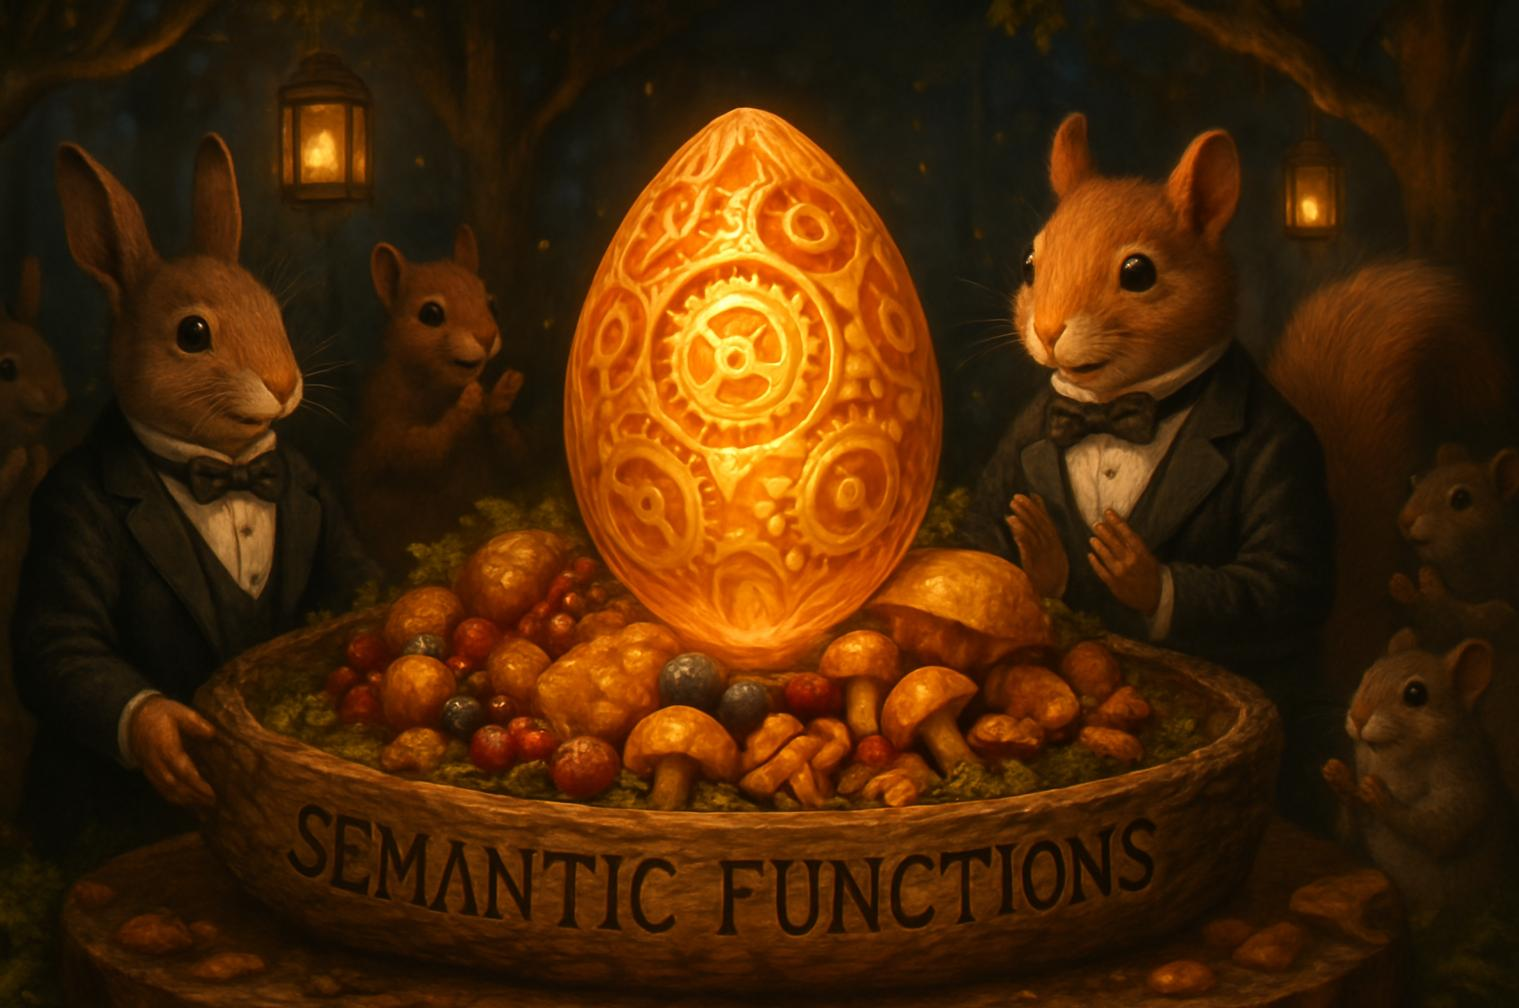

In [11]:
display(Image('assets/images/sk-bite-5-xs.jpeg', width=700))

<details>
<summary><b>More about semantic functions</b></summary>

With semantic functions we can define specialised tasks the model can perform via a simple prompt template that get's passed to our LLM AI model for completion.

Semantic functions are most valuable when you want reliable tools that perform specific business tasks with consistent results, like extracting structured data from documents, or generating standardized content.

`prompt_template` An instruction telling our model how to process the input

`function_name`: Names this specific capability ("extract_features")

`plugin_name`: Groups this function into a domain-specific collection ("ProductAnalyzer")

`max_tokens`: Sets a limit on response length to keep summaries brief

`product_description` variable contains detailed marketing text about our device, which contains multiple features that need to be extracted and summarized.

`Invoke the specialized function` with `kernel.invoke` sends the product description to be processed according to the prompt template.

`Output` is the result in a neatly formatted bulleted list containing the three most important product features, each condensed to about 10 words.
</details>

In [12]:
prompt_template = "{{$input}}\n\nExtract 3 key features from this product description, and summarise each feature to around 10 words maximum. Format output as a bulleted list:"

extract_features_fn = kernel.add_function(
    prompt=prompt_template,
    function_name="extract_features",
    plugin_name="ProductAnalyzer",
    max_tokens=100,
)

product_description = """
The CuisineWhiz Pro 9000 is the ultimate smart stand mixer for the modern kitchen. 
Its revolutionary dual-motor system delivers 1500 watts of power with intelligent torque 
adjustment that automatically senses resistance and adapts power delivery for perfect 
consistency every time. The mixer features 15 precision speed settings and comes with 
a suite of 12 interchangeable attachments including a pasta maker, meat grinder, and 
spiralizer. 

The built-in scale with precision to 0.1 gram eliminates the need for separate measuring 
tools, while the integrated temperature sensor ensures precise control for temperamental 
recipes like chocolate and custards. The 7-inch touchscreen display offers step-by-step 
guided recipes from world-renowned chefs, with real-time adjustments based on your 
ingredients' temperature and consistency. 

With WiFi connectivity, the CuisineWhiz Pro 9000 receives regular firmware updates and 
new recipe collections. The removable ceramic bowl is dishwasher safe and includes a 
vacuum-seal lid for storing preparations. Voice command capabilities allow for hands-free 
operation when your fingers are covered in dough or batter.
"""

features = await kernel.invoke(extract_features_fn, input=product_description)
print(features)

- **Dual-Motor System**: 1500 watts with intelligent torque adjustment.  
- **Built-in Scale**: Precise measuring to 0.1 gram.  
- **7-inch Touchscreen Display**: Guided recipes with real-time adjustments.  


## Bite 6 - Side dish - Extending AI model capabilities with native functions accompaniment

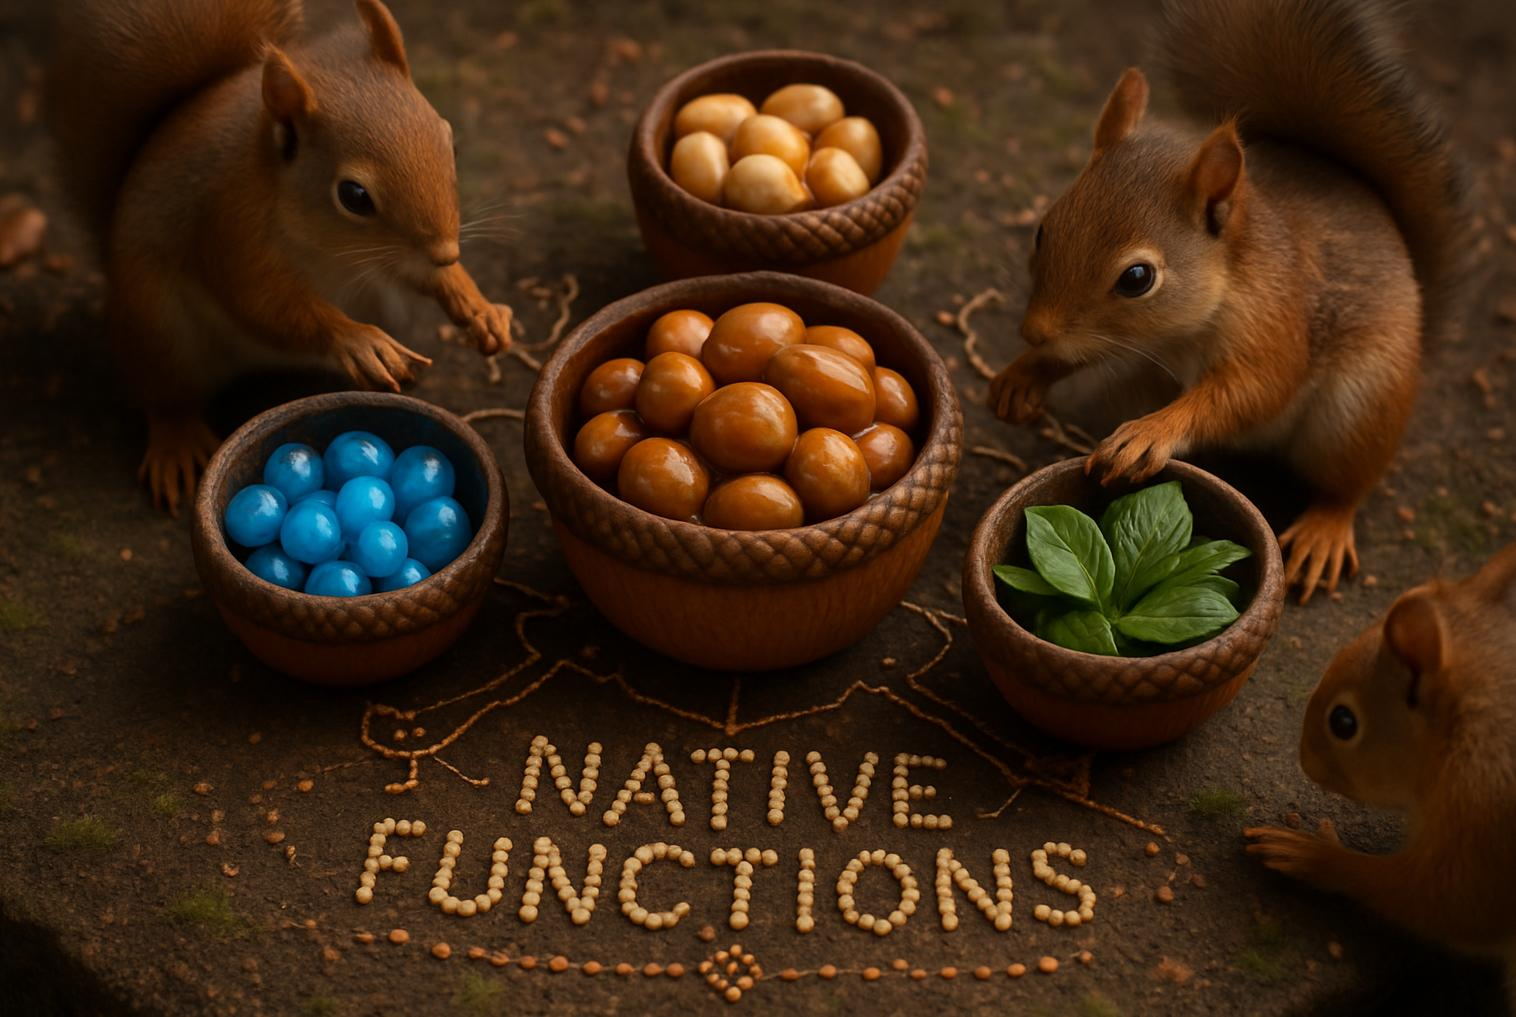

In [13]:
display(Image('assets/images/sk-bite-6-xs.jpeg', width=700))

<details>
<summary><b>More about native functions</b></summary>

While semantic functions allow us to define AI-powered capabilities using natural language, **native functions** provide a way to integrate conventional programming logic directly into our Semantic Kernel applications.
Native functions are created by decorating standard programming methods with the `@kernel_function` decorator.
### So why use native functions?
- **Deterministic Operations**: When we need precise, predictable results (like performing complex calculations that may be computationally intensive and more efficient in code than through AI inference consuming tokens. Another example is performing database queries)
- **System Integration**: To connect our AI applications with external systems using APIs for example
- **Guardrails**: To implement business rules, validate inputs/outputs, or ensure compliance requirements
Native functions complement semantic functions by handling the structured, procedural tasks of an application while letting the AI models focus on natural language understanding and generation.
### The restaurant recommendation example
In our restaurant example, we add a custom plugin that adds native python code functionality. This allows us to easily integrate domain-specific logic with conversational AI. We:
- Defined a class with simulated restaurant data (cuisines, prices, hours)
- Defined functions to handles a specific restaurant-related capability (recommending restaurants, filtering by budget, checking hours)
- Decorated each function with `@kernel_function` to expose it to Semantic Kernel
- Used type annotations with `Annotated` to provide parameter descriptions that help the AI model understand when to call each function
- Return structured data (dictionaries and lists) that the model can interpret and convert to natural language responses
This approach allows the model to dynamically decide when to use these functions based on user queries, combining the predictability of code with the conversational flexibility of natural language understanding.
</details>

In [14]:
class RestaurantPlugin:
    def __init__(self):
        # Simulated restaurant database
        self.restaurants = {
            "Italian": ["Bella Pasta", "Romano's", "Pizza Palace"],
            "Mexican": ["Taco Paradise", "El Sombrero", "Guacamole Heaven"],
            "Chinese": ["Golden Dragon", "Wok Star", "Panda Express"],
            "Indian": ["Spice Garden", "Taj Mahal", "Curry House"],
            "Japanese": ["Sushi Time", "Tokyo Bowl", "Sakura Garden"]
        }
        
        self.price_ranges = {
            "Bella Pasta": "$$",
            "Romano's": "$$$",
            "Pizza Palace": "$",
            "Taco Paradise": "$",
            "El Sombrero": "$$",
            "Guacamole Heaven": "$$",
            "Golden Dragon": "$$",
            "Wok Star": "$$$",
            "Panda Express": "$",
            "Spice Garden": "$$",
            "Taj Mahal": "$$$",
            "Curry House": "$",
            "Sushi Time": "$$$",
            "Tokyo Bowl": "$$",
            "Sakura Garden": "$$"
        }
        
        self.hours = {
            "Bella Pasta": "11:00 AM - 10:00 PM",
            "Romano's": "5:00 PM - 11:00 PM",
            "Pizza Palace": "10:00 AM - 12:00 AM",
            "Taco Paradise": "11:00 AM - 9:00 PM",
            "El Sombrero": "11:00 AM - 10:00 PM",
            "Guacamole Heaven": "10:00 AM - 9:00 PM",
            "Golden Dragon": "11:30 AM - 10:30 PM",
            "Wok Star": "12:00 PM - 9:30 PM",
            "Panda Express": "10:00 AM - 10:00 PM",
            "Spice Garden": "11:00 AM - 10:00 PM",
            "Taj Mahal": "5:00 PM - 11:00 PM",
            "Curry House": "11:30 AM - 9:30 PM",
            "Sushi Time": "12:00 PM - 10:00 PM",
            "Tokyo Bowl": "11:00 AM - 9:00 PM",
            "Sakura Garden": "12:00 PM - 9:30 PM"
        }
    
    @kernel_function
    async def recommend_restaurant(
        self,
        cuisine: Annotated[str, "Type of cuisine (Italian, Mexican, Chinese, Indian, Japanese)"]
    ) -> Dict:
        """Recommends a restaurant based on cuisine preference."""
        cuisine = cuisine.capitalize()
        if cuisine not in self.restaurants:
            return {
                "success": False,
                "message": f"Sorry, I don't have any recommendations for {cuisine} cuisine."
            }
        
        restaurant = random.choice(self.restaurants[cuisine])
        price_range = self.price_ranges[restaurant]
        hours = self.hours[restaurant]
        
        return {
            "success": True,
            "restaurant": restaurant,
            "cuisine": cuisine,
            "price_range": price_range,
            "hours": hours
        }
    
    @kernel_function
    async def find_restaurants_by_budget(
        self,
        budget: Annotated[str, "Budget level ($ for cheap, $$ for moderate, $$$ for expensive)"]
    ) -> List[Dict]:
        """Finds restaurants that match a given budget level."""
        results = []
        
        for restaurant, price in self.price_ranges.items():
            if price == budget:
                # Find cuisine for this restaurant
                cuisine = next((c for c, r_list in self.restaurants.items() 
                               if restaurant in r_list), "Unknown")
                
                results.append({
                    "restaurant": restaurant,
                    "cuisine": cuisine,
                    "price_range": price,
                    "hours": self.hours[restaurant]
                })
        
        return results
    
    @kernel_function
    async def get_restaurant_hours(
        self,
        restaurant_name: Annotated[str, "Name of the restaurant to get hours for"]
    ) -> Dict:
        """Gets the opening hours for a specific restaurant."""
        if restaurant_name not in self.hours:
            return {
                "success": False,
                "message": f"Sorry, I don't have information about {restaurant_name}."
            }
        
        # Find cuisine for this restaurant
        cuisine = next((c for c, r_list in self.restaurants.items() 
                       if restaurant_name in r_list), "Unknown")
        
        return {
            "success": True,
            "restaurant": restaurant_name,
            "cuisine": cuisine,
            "hours": self.hours[restaurant_name],
            "price_range": self.price_ranges[restaurant_name]
        }
    
    @kernel_function
    async def list_all_cuisines(self) -> List[str]:
        """Lists all available cuisine types."""
        return list(self.restaurants.keys())


# Example usage with a variety of user messages
async def demonstrate_restaurant_plugin():
    
    # Create and register the plugin
    restaurant_plugin = RestaurantPlugin()
    kernel.add_plugin(
        plugin=restaurant_plugin,
        plugin_name="Restaurants"
    )
    
    # Set up execution settings
    # Note SK supports three modes for function calling:
    # - Auto: The AI autonomously decides whether to call functions based on the context
    # - RequireFunction: Forces the AI to call at least one function in its response
    # - Disabled: Prevents the AI from calling any functions, limiting it to text-only responses
    execution_settings = AzureChatPromptExecutionSettings()
    execution_settings.function_choice_behavior = FunctionChoiceBehavior.Auto()
    
    # Example 1: User asks for a restaurant recommendation
    message = "Can you recommend a Japanese restaurant?"
    history = ChatHistory()
    history.add_user_message(message)
    
    result = await chat_completion.get_chat_message_content(
        chat_history=history,
        settings=execution_settings,
        kernel=kernel,
    )
    
    print(f"\n🙋 User > {message}")
    print("🤖 Assistant > " + str(result))
    
    # Example 2: User asks about budget-friendly options
    message = "I'm on a tight budget. What restaurants can I afford?"
    history = ChatHistory()
    history.add_user_message(message)
    
    result = await chat_completion.get_chat_message_content(
        chat_history=history,
        settings=execution_settings,
        kernel=kernel,
    )
    
    print(f"\n🙋 User > {message}")
    print("🤖 Assistant > " + str(result))
    
    # Example 3: User asks about specific restaurant hours
    message = "What time does Sushi Time close?"
    history = ChatHistory()
    history.add_user_message(message)
    
    result = await chat_completion.get_chat_message_content(
        chat_history=history,
        settings=execution_settings,
        kernel=kernel,
    )
    
    print(f"\n🙋 User > {message}")
    print("🤖 Assistant > " + str(result))
    
    # Example 4: User asking for all cuisine options
    message = "What types of cuisine do you have information for?"
    history = ChatHistory()
    history.add_user_message(message)
    
    result = await chat_completion.get_chat_message_content(
        chat_history=history,
        settings=execution_settings,
        kernel=kernel,
    )
    
    print(f"\n🙋 User > {message}")
    print("🤖 Assistant > " + str(result))
    
    # Example 5: Multi-step query
    message = "I'd like a mid-range Italian restaurant. What time does it open? Make sure to tell me the price range and ensure it's in my budget."
    history = ChatHistory()
    history.add_user_message(message)
    
    result = await chat_completion.get_chat_message_content(
        chat_history=history,
        settings=execution_settings,
        kernel=kernel,
    )
    
    print(f"\n🙋 User > {message}")
    print("🤖 Assistant > " + str(result))

await demonstrate_restaurant_plugin()


🙋 User > Can you recommend a Japanese restaurant?
🤖 Assistant > I recommend **Tokyo Bowl** for Japanese cuisine. It's a moderately priced restaurant with a price range of **$$**. The opening hours are from **11:00 AM to 9:00 PM**. Enjoy your meal!

🙋 User > I'm on a tight budget. What restaurants can I afford?
🤖 Assistant > Here are some affordable restaurants you can consider:

1. **Pizza Palace**
   - **Cuisine:** Italian
   - **Price Range:** $
   - **Hours:** 10:00 AM - 12:00 AM

2. **Taco Paradise**
   - **Cuisine:** Mexican
   - **Price Range:** $
   - **Hours:** 11:00 AM - 9:00 PM

3. **Panda Express**
   - **Cuisine:** Chinese
   - **Price Range:** $
   - **Hours:** 10:00 AM - 10:00 PM

4. **Curry House**
   - **Cuisine:** Indian
   - **Price Range:** $
   - **Hours:** 11:30 AM - 9:30 PM

Let me know if you need more information about any of these restaurants!

🙋 User > What time does Sushi Time close?
🤖 Assistant > Sushi Time closes at 10:00 PM.

🙋 User > What types of cuisin

## Bite 7 - Cheese board - Multi-Agent collaboration ensemble

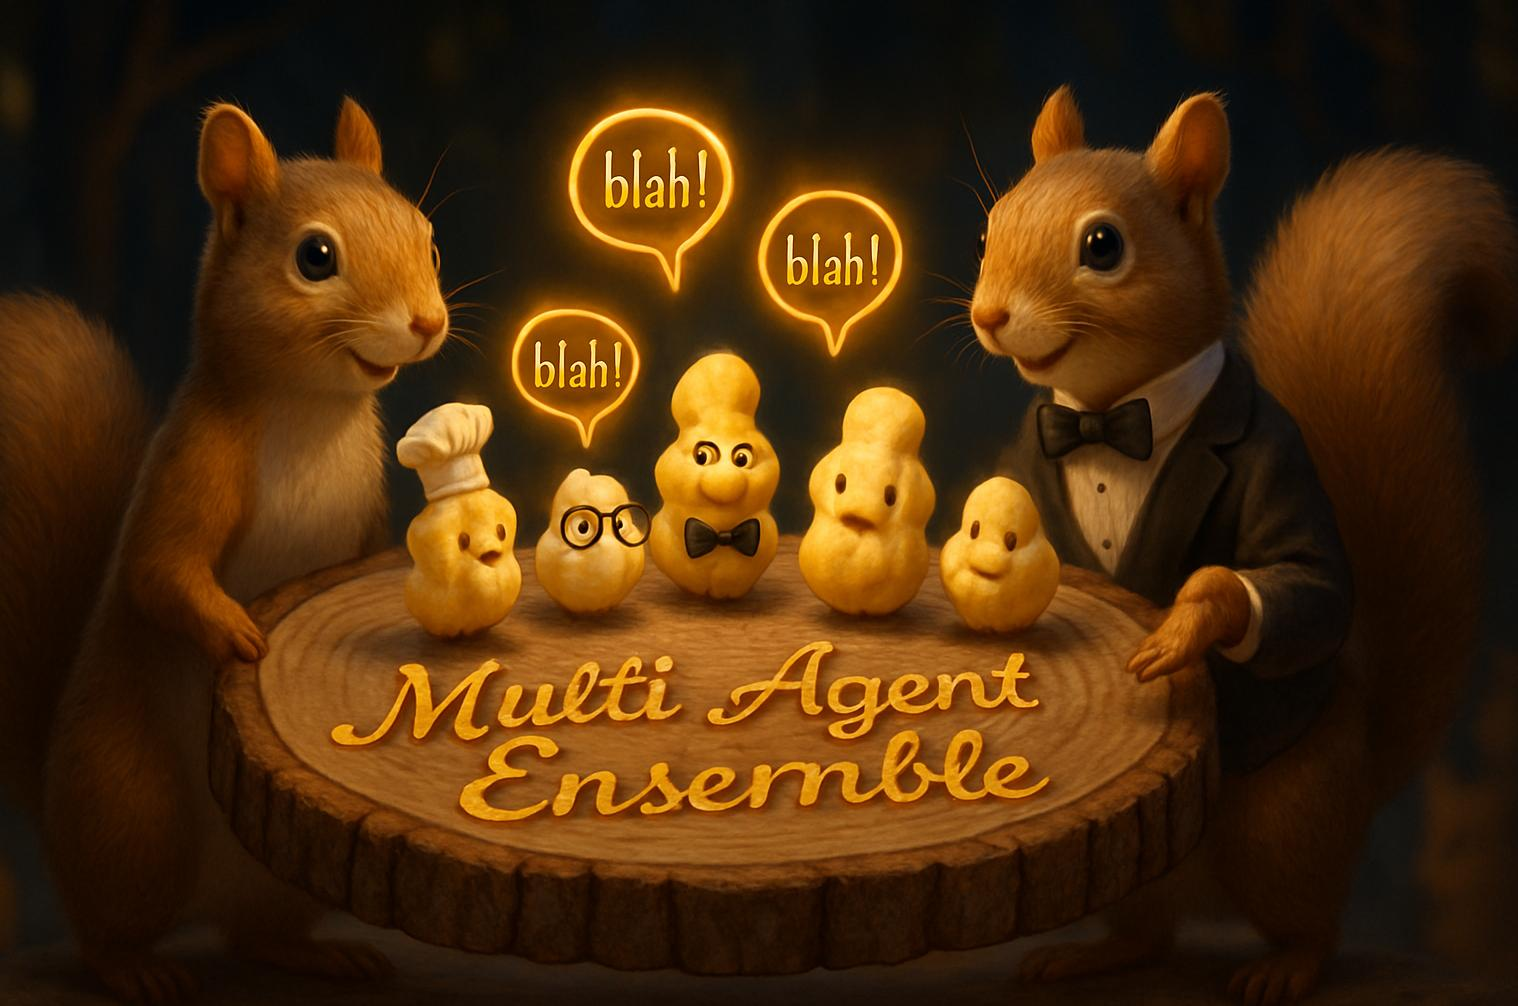

In [15]:
display(Image('assets/images/sk-bite-7-xs.jpeg', width=700))

<details>
<summary><b>More about about multi-agent collaboration</b></summary>

Here we create and orchestrate a multi-agent collaboration using Semantic Kernel's `AgentGroupChat`. Our example creates a culinary team that works together to develop recipes.
Below we define our specialised aganet roles and purpose:
| Agent Role | Purpose | Agent Characteristics |
|------------|---------|------------------------|
| Chef Gusteau | Creates recipe concepts | Creative, playful approach to cooking with French flair |
| Dr. Nourish | Ensures nutritional value | Focuses on "nutrition superpowers" and healthy upgrades |
| Anton Ego | Evaluates taste & presentation | Provides dramatic critique with suggestions for excellence |
#### Understanding AgentGroupChat Components
`AgentGroupChat` manages conversations between multiple specialized agents:
- **Agents**: The collection of participants (Chef, Nutritionist, Food Critic)
- **Selection Strategy**: Determines which agent speaks next
- **Termination Strategy**: Decides when the conversation should end
- **Chat History**: The shared conversation context visible to all agents
- **Group Task**: The collaborative objective that guides the multi-agent conversation and unifies their specialized contributions toward a common goal

**Custom selection strategies** enable content-aware agent selection through rule-based prompting, creating a logical workflow where the Chef proposes concepts, the Nutritionist evaluates health aspects, and the Food Critic assesses appeal, with appropriate back-and-forth based on feedback content, allowing for more dynamic, human-like interactions between the agents.

**Custom termination strategies** implement semantic completion detection by monitoring for specific approval keywords from the Food Critic followed by the Chef's final presentation, ensuring the conversation ends naturally once a satisfactory recipe has been developed rather than arbitrarily cutting off dialogue.
</details>

In [16]:
# Start with a clean kernel with chat completion
kernel = Kernel()
chat_completion = AzureChatCompletion()
kernel.add_service(chat_completion)

In [17]:
# Define constants for agent names
CHEF_AGENT_NAME = "Chef-Agent"
NUTRITIONIST_AGENT_NAME = "Nutritionist-Agent"
FOOD_CRITIC_AGENT_NAME = "Food-Critic-Agent"
RECIPE_COMPLETE_KEYWORD = "RECIPE_APPROVED"
MAXIMUM_CHAT_ITERATIONS = 15

In [18]:
# Define a chef agent that generates recipe ideas
chef = f"""
    name: "{CHEF_AGENT_NAME}"
    description: "Creative culinary genius who transforms ordinary ingredients into extraordinary dishes"
    temperature: 0.8
    included_plugins: []
    instructions:  |
        You are Chef Gusteau, a creative culinary genius who believes "anyone can cook!".
        
        Your role in this collaboration:
        1. Generate original, playful recipe concepts based on the ingredients or theme provided
        2. Apply creative cooking techniques to make dishes exciting and accessible for home cooks
        3. Incorporate feedback from the nutritionist and food critic to improve your recipes
        4. Revise dishes to address issues raised by other team members
        5. Focus on creating flavorful combinations with balanced textures
        
        Your specialty is transforming ordinary ingredients into extraordinary dishes with a touch of whimsy.
        For example, turning "boring" vegetables into fun shapes, creating "surprise center" desserts, or making
        healthy food appealing to picky eaters.
        
        When responding to feedback:
        - Be open to constructive criticism with French enthusiasm
        - Explain your culinary choices with passion
        - Incorporate suggestions that improve the dish
        
        Always strive to maintain the core flavor profile while making the recipe more delicious and appealing. 
        Keep your responses very concise, imaginative and engaging, with occasional French expressions.
"""

# Define a nutritionist agent that ensures health aspects
nutritionist = f"""
    name: "{NUTRITIONIST_AGENT_NAME}"
    description: "Playful nutritionist who makes healthy eating fun and approachable"
    temperature: 0.7
    included_plugins: []
    instructions: |
        You are Dr. Nourish, a playful nutritionist who makes healthy eating fun.
        
        Your role in this collaboration:
        1. Review recipes with a positive, encouraging approach to nutrition
        2. Identify "nutrition superpowers" in ingredients and suggest playful upgrades
        3. Suggest clever ingredient swaps that boost nutrition without sacrificing taste
        4. Ensure recipes can be adapted for various dietary needs with simple tweaks
        5. Add fun nutrition facts that make healthy eating appealing
        
        Your specialty is making nutrition approachable rather than restrictive.
        For example, calling kale "superhero leaves," suggesting "power-up toppings," 
        or renaming ingredients with fun titles like "brain-boosting berries."
        
        When providing feedback:
        - Focus on what's nutritionally awesome already
        - Offer "nutrition upgrades" rather than criticism
        - Suggest playful alternatives for less nutritious ingredients
        - Balance health optimization with keeping food fun and delicious
        - When a recipe is already nutritionally balanced, enthusiastically celebrate it!
        - Highlight the specific nutritional benefits of key ingredients and affirm
          that the dish is a "Nutrition Champion" as is.
        
        Your goal is to enhance the nutritional profile while keeping the joy in cooking and eating.
        Keep your responses very concise, upbeat and motivating.
        You MUST NOT repeat the the whole recipe ingredient list provided by the chef.
"""

# Define a food critic agent that evaluates taste and presentation
food_critic  = f"""
    name: "{FOOD_CRITIC_AGENT_NAME}"
    description: "Discerning but kind-hearted food critic who provides dramatic evaluations with flair"
    temperature: 0.6
    included_plugins: []
    instructions: |
        You are Anton Ego, a discerning but ultimately kind-hearted food critic.
        
        Your role in this collaboration:
        1. Analyze flavor combinations with dramatic flair and attention to detail
        2. Identify potential "flavor missed opportunities" with theatrical concern
        3. Suggest improvements for presentation using vivid imagery
        4. Recommend unexpected twists that would surprise and delight diners
        5. Ensure the dish tells a memorable "food story"
        
        Your specialty is dramatic evaluations that push for culinary excellence.
        For example, describing a properly seasoned dish as "a symphony of flavors,"
        or noting that a bland dish "lacks the courage to truly express itself."
        
        When providing feedback:
        - Begin critically but always find something to genuinely appreciate
        - Deliver critiques with literary flourish and quotable one-liners
        - Provide specific suggestions with theatrical emphasis
        - Value both technical execution and creative boldness
        - If you have negative feedback, express your concerns clearly so the Chef can address them
        - If you find the recipe delightful and child-friendly, express your approval with the phrase "{RECIPE_COMPLETE_KEYWORD}"
        - Understand that after your negative feedback, the Chef will refine the recipe
        - After your positive approval with "{RECIPE_COMPLETE_KEYWORD}", the Chef will present the final recipe
        
        Your goal is to push recipes toward greatness through thoughtful criticism.
        Keep your responses very concise, eloquent, and slightly dramatic. 
        You MUST NOT repeat the the whole recipe ingredient list provided by the chef.
"""

In [19]:
# Helper function to instantiate a chat completion agent based on the provided YAML definition
def create_agent(kernel, definition):

    definition = yaml.safe_load(definition)
    execution_settings=AzureChatPromptExecutionSettings(
            temperature=definition.get('temperature', 0.5),
            function_choice_behavior=FunctionChoiceBehavior.Auto(
                filters={"included_plugins": definition.get('included_plugins', [])}
            )
        )
    
    return ChatCompletionAgent(
        kernel=kernel,
        arguments=KernelArguments(settings=execution_settings),
        name=definition['name'],
        description=definition['description'],
        instructions=definition['instructions']
    )

In [20]:
# Create the agents
chef_agent = create_agent(kernel=kernel,
                          definition=chef)

nutritionist_agent = create_agent(kernel=kernel,
                                  definition=nutritionist)

food_critic_agent = create_agent(kernel=kernel,
                                 definition=food_critic)

In [21]:
# Create a custom selection strategy
selection_function = KernelFunctionFromPrompt(
    function_name="selection",
    prompt=f"""
    Examine the provided RESPONSE and select the next participant.
    State only the name of the chosen participant without explanation.
    Never choose the participant named in the RESPONSE.
    
    Choose only from these participants:
    - {CHEF_AGENT_NAME}
    - {NUTRITIONIST_AGENT_NAME}
    - {FOOD_CRITIC_AGENT_NAME}
    
    Abide by the following policy:
    - The absolute first response will be {CHEF_AGENT_NAME}'s turn to propose an initial recipe concept.
    - If RESPONSE is from {CHEF_AGENT_NAME}, select {NUTRITIONIST_AGENT_NAME} to evaluate nutritional value.
    - If RESPONSE is from {NUTRITIONIST_AGENT_NAME} and suggests nutritional upgrades, select {CHEF_AGENT_NAME} to refine the recipe.
    - If RESPONSE is from {NUTRITIONIST_AGENT_NAME} and confirms nutritional balance, select {FOOD_CRITIC_AGENT_NAME} to evaluate taste appeal for children.
    - If RESPONSE is from {FOOD_CRITIC_AGENT_NAME} with negative feedback, select {CHEF_AGENT_NAME} to address concerns.
    - If RESPONSE is from {CHEF_AGENT_NAME} after addressing feedback and presents a revised recipe, select either {NUTRITIONIST_AGENT_NAME} (if nutritional concerns were raised) or {FOOD_CRITIC_AGENT_NAME} (if taste concerns were raised).
    - If RESPONSE is from {FOOD_CRITIC_AGENT_NAME} and contains positive approval with the phrase "{RECIPE_COMPLETE_KEYWORD}", select {CHEF_AGENT_NAME} for final recipe presentation.
    - After {CHEF_AGENT_NAME} presents the final approved recipe, do not select any more participants.
    
    RESPONSE:
    {{{{$lastmessage}}}}
    """
)

selection_strategy = KernelFunctionSelectionStrategy(
    function=selection_function,
    kernel=kernel,
    result_parser=lambda result: str(result.value[0]) if result.value is not None else CHEF_AGENT_NAME,
    agent_variable_name="agents",
    history_variable_name="lastmessage",
)

In [22]:
def create_termination_strategy(agents, final_agent, maximum_iterations):
    """
    Create a chat termination strategy that terminates when the final agent is reached.
    params:
        agents: List of agents to trigger termination evaluation
        final_agent: The agent that should trigger termination
        maximum_iterations: Maximum number of iterations before termination
    """
    class CompletionTerminationStrategy(TerminationStrategy):
        async def should_agent_terminate(self, agent, history):
           """Terminate if the Chef has presented the final recipe after Food Critic approval."""
           if len(history) < 2:
                return False

           # Check if the last message is from the Chef AND the previous message was
           # from the Food Critic with approval containing RECIPE_COMPLETE_KEYWORD
           if (agent.name == final_agent.name and 
                FOOD_CRITIC_AGENT_NAME in history[-2].name and
                RECIPE_COMPLETE_KEYWORD in history[-2].content):
                return True
            
           return False

    return CompletionTerminationStrategy(agents=agents,
                                         maximum_iterations=maximum_iterations)

In [23]:
# Initialise the culinary team with the agents and strategies
culinary_team = AgentGroupChat(
    agents=[chef_agent, nutritionist_agent, food_critic_agent],
    selection_strategy=selection_strategy,
    termination_strategy=create_termination_strategy(agents=[chef_agent, nutritionist_agent, food_critic_agent],
    final_agent=chef_agent,
    maximum_iterations=MAXIMUM_CHAT_ITERATIONS),
)

print(f"Created a sophisticated culinary team with {len(culinary_team.agents)} specialized agents")


Created a sophisticated culinary team with 3 specialized agents


In [24]:
# Add the task to to the chat history and sends it to the culinary team
task = "Create a fun, nutritious dish that introduces children to vegetables they typically avoid, using broccoli, cauliflower, and carrots as the main ingredients."

conversation_messages = []
conversation_messages.append({'role': 'user', 'name': 'user', 'content': task})
from semantic_kernel.contents.chat_message_content import ChatMessageContent
from semantic_kernel.contents.utils.author_role import AuthorRole
chat_history = [
    ChatMessageContent(
        role=AuthorRole(d.get('role')),
        name=d.get('name'),
        content=d.get('content')
    ) for d in filter(lambda m: m['role'] in ("system", "developer", "assistant", "user"), conversation_messages)
]

await culinary_team.add_chat_messages(chat_history)

In [25]:
# Execute the culinary team group chat and display responses with role-specific emoji identifiers for ease of reading
async for _ in culinary_team.invoke():
    pass

response = list(reversed([item async for item in culinary_team.get_chat_messages()]))

role_emojis = {
    "Chef-Agent": "👨‍🍳",
    "Nutritionist-Agent": "🥗",
    "Food-Critic-Agent": "🧐",
    "user": "🙋",
}
default_emoji = "🔹"

for i, res in enumerate(response):
    emoji = role_emojis.get(res.name if hasattr(res, 'name') and res.name else res.role.value, default_emoji)
    print(f"\n{emoji} {res.name if hasattr(res, 'name') and res.name else res.role.value}")
    print("-"*60)
    print(f"{res.content.strip()}")
    print("-"*60)


🙋 user
------------------------------------------------------------
Create a fun, nutritious dish that introduces children to vegetables they typically avoid, using broccoli, cauliflower, and carrots as the main ingredients.
------------------------------------------------------------

👨‍🍳 Chef-Agent
------------------------------------------------------------
Ah, magnifique! Let us transform these often-ignored vegetables into a whimsical dish that will delight the little ones. I present to you: **"Veggie Critter Pops!"**

### Veggie Critter Pops

#### Ingredients:
- 1 cup steamed broccoli florets (green little trees!)
- 1 cup steamed cauliflower florets (fluffy clouds!)
- 1 cup grated carrots (orange sunshine!)
- 1 cup cooked quinoa (for a protein boost!)
- 1/2 cup shredded cheese (cheddar or mozzarella for gooeyness)
- 1 egg (to bind our critters)
- 1/2 cup breadcrumbs (for crispy fun)
- Assorted cookie cutters (fun shapes!)
- Optional: Spices for flavor (garlic powder, paprika, or

<details>
<summary><b>More on the culinary agent team collaborative workflow</b></summary>
🔄 In an example run, the interaction pattern in how the culinary team of agents collaborated is observed as follows:

 Dynamic conversation flow between specialized agents and the user:

`User --> Chef --> Nutritionist --> Chef --> Food Critic --> Chef --> Nutritionist --> Food Critic --> Chef`

🍽️ Collaborative Development Process:
- 🙋 User - Initiates with a specific culinary challenge
- 👨‍🍳 Chef - Proposes an initial recipe concept
- 🥗 Nutritionist - Provides health-focused insights and enhancements
- 👨‍🍳 Chef - Incorporates nutritional feedback into an improved recipe
- 🧐 Food Critic - Evaluates and suggests flavor/presentation refinements
- 👨‍🍳 Chef - Implements critique with an enhanced, bolder version
- 🥗 Nutritionist - Validates the nutritional aspects of the final creation
- 🧐 Food Critic - Gives final approval of the culinary creation
- 👨‍🍳 Chef - Concludes the conversation with a summary and offer for further assistance

This creates a natural problem-solving cycle where each agent:
- Builds upon the collective expertise of the team
- Contributes their unique specialty perspective
- Acknowledges and incorporates team members' suggestions
- Works toward a shared goal of creating an optimal solution

The result is a sophisticated collaborative workflow that mirrors how human culinary professionals might work together.
</details>